In [1]:
TEST_SIZE = 0.3
RANDOM_STATE = 42
BATCH_SIZE = 64 #número de amostras usadas antes de uma atualização dos pesos
EPOCHS = 200
LR = 0.0005 #learning of rate: o tamanho do passo que o otimizador dá ao ajustar os pesos da rede em cada iteração. Quanto o modelo “aprende” de cada vez.
DEVICE = None  # 'cuda' ou 'cpu'

from sklearn.preprocessing import StandardScaler

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False


from sklearn.metrics import roc_auc_score
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.combine import SMOTEENN
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, matthews_corrcoef
import pandas as pd
import seaborn as sn
import kagglehub as kh
import matplotlib.pyplot as plt
import os
import numpy as np     

import warnings
warnings.filterwarnings('ignore')
sn.set_style('darkgrid', {'axes.facecolor': '0.9'})

print(f"Torch disponível: {TORCH_AVAILABLE}")

#teste de manter reprotubilidade
SEED = 42

import time
import datetime
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

/home/ubuntu-user/anaconda3/lib/python3.12/site-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


Torch disponível: True


In [2]:
path = kh.dataset_download("mlg-ulb/creditcardfraud")
print("Caminho para o Dataset:", path)
os.listdir(path)

df = pd.read_csv(path + "/creditcard.csv")
df.tail()

print('Formato do dataset:', df.shape)
print(df['Class'].value_counts())

expected_pca = [f'V{i}' for i in range(1,29)]
missing = [c for c in expected_pca if c not in df.columns]
if missing:
    print('Aviso: colunas PCA ausentes:', missing)

features = [c for c in df.columns if c != 'Class' or c != 'Time']
X = df[features].copy()
y = df['Class'].copy()

scaler = StandardScaler()
if 'Amount' in X.columns:
    X['Amount'] = scaler.fit_transform(X[['Amount']])

X = X.fillna(0)


Caminho para o Dataset: /home/ubuntu-user/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
Formato do dataset: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print('Distribuição treino:\n', y_train.value_counts())
print('Distribuição teste:\n', y_test.value_counts())

Distribuição treino:
 Class
0    199020
1       344
Name: count, dtype: int64
Distribuição teste:
 Class
0    85295
1      148
Name: count, dtype: int64


(-1.1, 1.1)

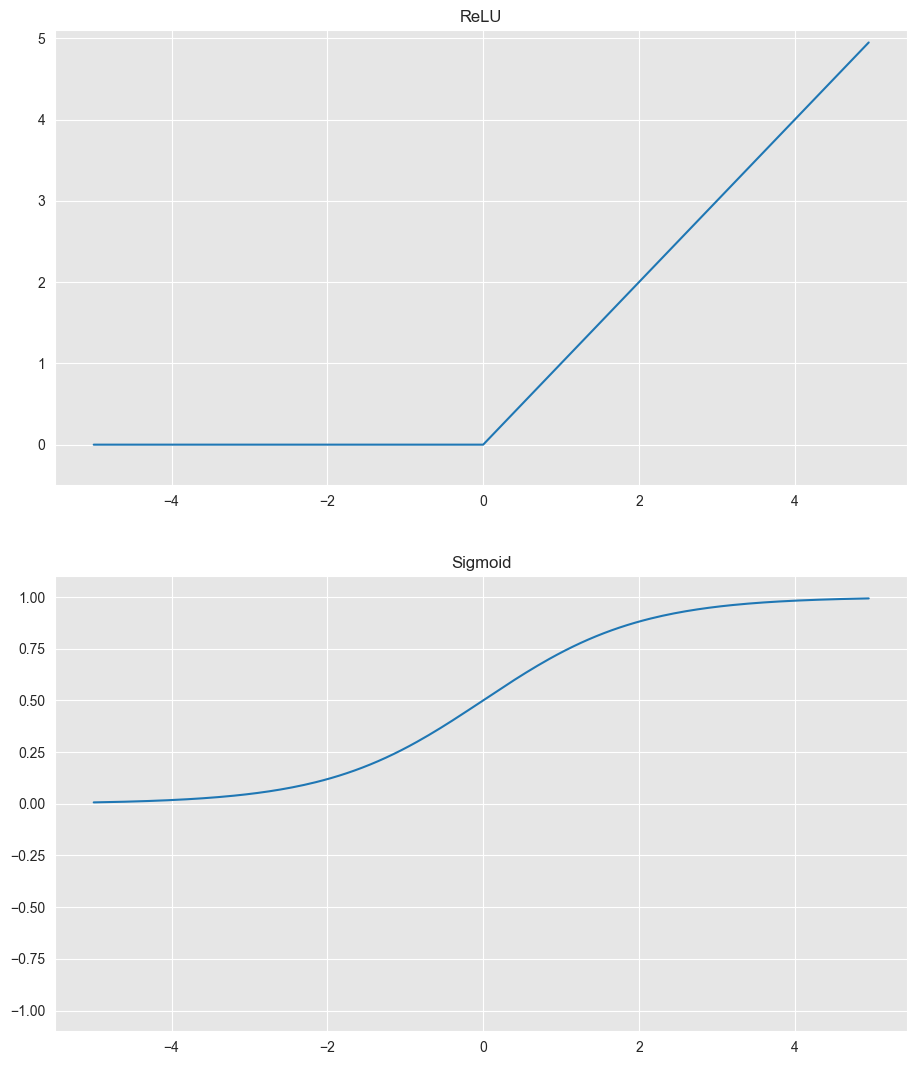

In [4]:
fig_activation, axs = plt.subplots(2,figsize=(11, 13))

input_values = torch.arange(-5, 5, 0.05)

#relu activation
activation = torch.nn.ReLU()
output_values = activation(input_values)
axs[0].plot(input_values, output_values)
axs[0].set_title('ReLU')
axs[0].set_ylim([-0.5,5.1])

#sigmoid activation
activation = torch.nn.Sigmoid()
output_values = activation(input_values)
axs[1].plot(input_values, output_values)
axs[1].set_title('Sigmoid')
axs[1].set_ylim([-1.1,1.1])

In [5]:
def compute_metrics(y_true, y_pred, y_proba=None):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return dict(precision=p, recall=r, f1=f1, accuracy=acc, mcc=mcc, auc=auc)


def evaluate_model(model,val_loader,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in val_loader:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss

class EarlyStopping:
    def __init__(self, patience=2):
        self.patience = patience
        self.counter = 0
        self.best_score = np.inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            print("New best score:", current_score)
        else:
            self.counter+=1
            print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience  
    
class FraudDatasetTorch(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

class SimpleFraudMLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, p=0.2):
        super(SimpleFraudMLPWithDropout, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.p = p
            
        #input to hidden
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        #hidden to output
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
        self.dropout = torch.nn.Dropout(self.p)
            
    def forward(self, x):
        
        hidden = self.fc1(x)
        hidden = self.relu(hidden)
        
        hidden = self.dropout(hidden)
        
        output = self.fc2(hidden)
        output = self.sigmoid(output)
        
        return output

def train_pytorch_mlp(X_tr, y_tr, X_val, y_val, input_size, apply_early_stopping=True, max_epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SimpleFraudMLPWithDropout(input_size, 1000,0.2).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_ds = FraudDatasetTorch(X_tr, y_tr) #prepara os dados de treinamento para uso no Torch
    val_ds = FraudDatasetTorch(X_val, y_val) #prepara os dados de teste/validação para uso no Torch
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) #Facilitar a divisão em lote e aleatoriedade
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) #Facilitar a divisão em lote
    
    if apply_early_stopping:
        early_stopping = EarlyStopping(patience=2)
    
    model.train()
    all_train_losses = []
    all_valid_losses = []        

    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            # Removing previously computed gradients
            optimizer.zero_grad()
            # Performing the forward pass on the current batch
            preds = model(xb)
            # Computing the loss given the current predictions
            loss = criterion(preds.squeeze(), yb)
            # Computing the gradients over the backward pass
            loss.backward()
            # Performing an optimization step from the current gradients
            optimizer.step()
            # Storing the current step's loss for display purposes
            train_loss.append(loss.item())

        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        print("")        
        print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))

        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,val_loader,criterion)    
        all_valid_losses.append(valid_loss)
        print('valid loss: {}'.format(valid_loss))   
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                print("Early stopping")
                break

    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses


In [6]:
summary_rows = []
roc_data = {}

print('Original')

model,training_execution_time,train_losses,valid_losses = train_pytorch_mlp(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], apply_early_stopping=True)

print(training_execution_time)
metrics = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio='Original', model='FNN', **metrics))
roc_data["Original"] = y_proba

Original

Epoch 0: train loss: 0.227190355983701
valid loss: 0.1730938210270188
New best score: 0.1730938210270188

Epoch 1: train loss: 0.17249790454425698
valid loss: 0.17309179466446664
New best score: 0.17309179466446664

Epoch 2: train loss: 0.17249691962009409
valid loss: 0.17309148613004707
New best score: 0.17309148613004707

Epoch 3: train loss: 0.17249681908007675
valid loss: 0.17309134329568077
New best score: 0.17309134329568077

Epoch 4: train loss: 0.17249679325883924
valid loss: 0.17309132561738216
New best score: 0.17309132561738216

Epoch 5: train loss: 0.17249679112547298
valid loss: 0.1730913217056166
New best score: 0.1730913217056166

Epoch 6: train loss: 0.17249679112650163
valid loss: 0.17309131903391836
New best score: 0.17309131903391836

Epoch 7: train loss: 0.17249679082483932
valid loss: 0.17309131847148368
New best score: 0.17309131847148368

Epoch 8: train loss: 0.17249679081074293
valid loss: 0.17309131813965836
New best score: 0.17309131813965836

Epoch 

NameError: name 'predict_pytorch' is not defined

In [ ]:
summary_df = pd.DataFrame(summary_rows)
print('\nResumo das métricas:')
print(summary_df)

In [ ]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("Original")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])

In [ ]:
summary_rows = []
roc_data = {}

print('SMOTE-ENN 10 : 90')
smt = SMOTEENN(random_state=42, sampling_strategy=0.111)
X_train_sm_1090, y_train_sm_1090 = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_sm_1090)
print('Amostra balanceada:', np.bincount(y_train_sm_1090.astype(int)))

model,training_execution_time_sm_1090,train_losses_sm_1090,valid_losses_sm_1090 = train_pytorch_mlp(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], apply_early_stopping=True)

print(training_execution_time_sm_1090)
metrics = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio=f"{10}:{90}", model='FNN', **metrics))
roc_data[f"{10}:{90}"] = y_proba

In [ ]:
summary_df = pd.DataFrame(summary_rows)
print('\nResumo das métricas:')
print(summary_df)

In [ ]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("Original")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

plt.subplot(1, 2, 2) 
plt.plot(np.arange(len(train_losses_sm_1090))+1, train_losses_sm_1090)
plt.plot(np.arange(len(valid_losses_sm_1090))+1, valid_losses_sm_1090)
plt.title("10:90")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

In [ ]:
summary_rows = []
roc_data = {}

print('SMOTE-ENN 50 : 50')
smt = SMOTEENN(random_state=42)
X_train_sm_5050, y_train_sm_5050 = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_sm_5050)
print('Depois do SMOTE-ENN:', counter)

print('Amostra balanceada:', np.bincount(y_train_sm_5050.astype(int)))

model,training_execution_time_sm_5050,train_losses_sm_5050,valid_losses_sm_5050 = train_pytorch_mlp(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], apply_early_stopping=True)

print(training_execution_time_sm_5050)
metrics = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio=f"{50}:{50}", model='FNN', **metrics))
roc_data[f"{50}:{50}"] = y_proba


In [ ]:
summary_df = pd.DataFrame(summary_rows)
print('\nResumo das métricas:')
print(summary_df)

In [ ]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("Original")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

plt.subplot(1, 2, 2) 
plt.plot(np.arange(len(train_losses_sm_5050))+1, train_losses_sm_5050)
plt.plot(np.arange(len(valid_losses_sm_5050))+1, valid_losses_sm_5050)
plt.title("5050")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

In [ ]:
summary_df.to_csv('fnn_results_summary.csv', index=False)
print('Resultados salvos em fnn_results_summary.csv')

In [ ]:
# plt.subplot(1, 2, 1)
# plt.plot(np.arange(len(train_losses))+1, train_losses)
# plt.plot(np.arange(len(valid_losses))+1, valid_losses)
# plt.title("SGD")
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train','valid'])
# plt.ylim([0.01,0.06])

# plt.subplot(1, 2, 2) 
# plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
# plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
# plt.title("ADAM")
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train','valid'])
# plt.ylim([0.01,0.06])